In [6]:
# test_imports in this cell, restart kernel whenever edits to modules are made

import sys
import os
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

#import config based on which machine the jupyter notebook is running on
from configs.config_local import *
from preprocessing import *
from module_detection import *
from utils import *

def test_imports():
    print("testing config class")
    config = Config()
    print(config)

    print("testing 2d contacts preprocessing classes")
    query = HiCQuery(config, 'chr1', 1000000, '1Mb') #needs config, chrom and res/res0 for instantiation
    print(query)

    
    #other prints for imported classes

test_imports()

testing config class
testing 2d contacts preprocessing classes
HiC file loaded


## OE part of the pipeline

In [7]:
#initialising parameters for single chromosome analysis

config = Config()
chrom = config.genomic_params.chromosomes[0]
current_res = config.genomic_params.resolutions[0]  # 1Mb for OE part
current_res_str = config.genomic_params.res_strs[0]  # 1Mb for OE part
query = HiCQuery(config, chrom, current_res, current_res_str)

HiC file loaded


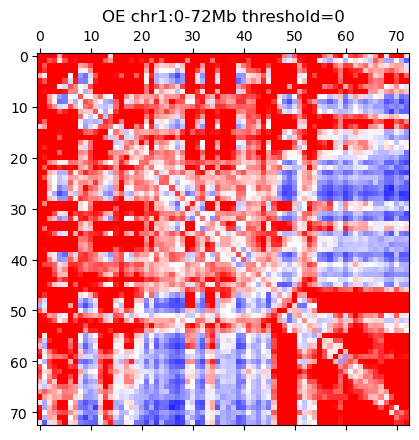

In [4]:
## TRYING DIFFERENT THRESHOLDS ##

# params for OE matrix visualisation
threshold = 0
start = 0
end = 72000000

# Custom colormap
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])

## single chr visualisation ##
oe_numpy_thresholded = query.oe_intra_numpy(start, end, threshold)
region_str = format_loci_string(start, end, current_res_str) 

def plot_single_hic_map(dense_matrix, cmap, vmin=0, vmax=30, title=""):
    d2 = dense_matrix
    d2[np.isnan(d2)] = 0
    d2[np.isinf(d2)] = 0
    plt.matshow(dense_matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.show()

plot_single_hic_map(oe_numpy_thresholded, 'bwr', 0, 1, f"OE {chrom}:{region_str} threshold={threshold}")

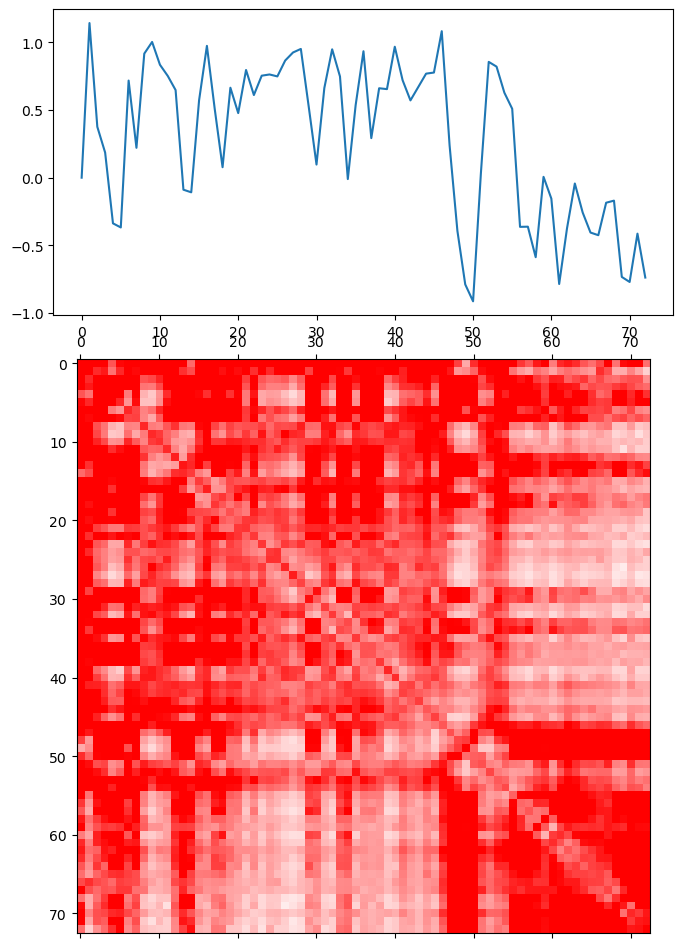

In [4]:
## Plot AB score with hic oe to see if +:A and -:B strategy is good or not##

def plot_2dhic_1dtrack_map(dense_matrix, signal, vmin, vmax, cmap):
  d2 = dense_matrix # np.log(dense_matrix)
  d2[np.isnan(d2)] = 0
  d2[np.isinf(d2)] = 0
  fig = plt.figure()
  fig.set_figheight(12)
  fig.set_figwidth(8)
  spec = gridspec.GridSpec(ncols=1, nrows=2,
                         width_ratios=[1], wspace=1,
                         hspace=.1, height_ratios=[16, 30])
  ax0 = fig.add_subplot(spec[0])
  ax0.plot(np.arange(len(signal)), signal)
  ax1 = fig.add_subplot(spec[1])
  ax1.matshow(d2, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()

# params for AB score visualisation along with OE matrix
ab_geo_bw = pyBigWig.open(config.paths.compartments_infile)
nm_bins = oe_numpy_thresholded.shape[0]
signal = ab_geo_bw.stats(
                chrom, start, end, type="mean", nBins=nm_bins
            )
#filter none values
filtered_signal = [0 if x is None else x for x in signal]
plot_2dhic_1dtrack_map(oe_numpy_thresholded, filtered_signal, 0, 1, REDMAP)

Filename: /Users/Akanksha/MaGroup/Genomic Hubs/3D_chromatin_hubs/src/preprocessing/hic_data_loader.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   141    277.2 MiB    277.2 MiB           1       @profile
   142                                             def oe_intra(self, threshold=0):
   143                                                 """
   144                                                 returns contact records for one chromosome as straw object, thresholded if needed
   145                                                 straw object : .binX [0] .binY [1] .counts [2] as attributes of list
   146                                                 """
   147    277.2 MiB      0.0 MiB           1           chrom = self.chrom[3:]
   148    277.2 MiB      0.0 MiB           1           res = int(self.res)
   149    280.1 MiB      2.9 MiB           2           oe_list = hicstraw.straw(
   150    277.2 MiB      0.0 MiB           1               "oe", self.hic_norm

/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_64127/1008850441.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


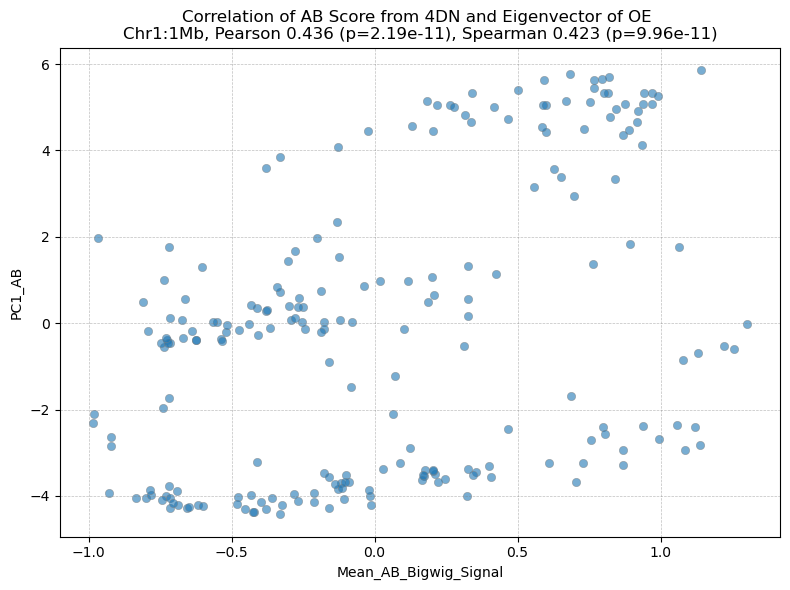

In [5]:
def plot_ab_score_correlation_scatter(correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p):
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(
        data=correlation_data, 
        x='Mean_AB_Bigwig_Signal', 
        y='PC1_AB', 
        palette={False: 'green', True: 'red'}, 
        legend='full',
        edgecolor='grey',  # Grey borders
        alpha=0.6
    )
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    handles, labels = scatter.get_legend_handles_labels()
    plt.title(f'Correlation of AB Score from 4DN and Eigenvector of OE \nChr1:1Mb, Pearson {pearson_corr:.3f} (p={pearson_p:.2e}), Spearman {spearman_corr:.3f} (p={spearman_p:.2e})')
    plt.xlabel('Mean_AB_Bigwig_Signal')
    plt.ylabel('PC1_AB')
    plt.tight_layout()
    plt.show()


## Get AB scores of the intra-chr OE matrix ##
oe_intra_csr = query.oe_straw_to_csr()
ab_score_dict = query.ab_comp.calculate_ab_score(oe_intra_csr) #send sparse matrix to calculate whole chr ab_score
print(ab_score_dict)
bigwig_signal_dict = query.ab_comp.load_bigwig_chromosomal_ab()
print(bigwig_signal_dict)

correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p = query.ab_comp.ab_score_correlation(ab_score_dict, bigwig_signal_dict)
# get outliers
#correlation_data['Outliers'] = (correlation_data['PC1_AB'] > 3) | (correlation_data['Mean_AB_Bigwig_Signal'].abs() > 0.0015)
#plot
plot_ab_score_correlation_scatter(correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p)

## Cluster performance accuracy and metrics

In [ ]:
#plot the affinity matrix
self.affinity_key = config.genomic_params.affinity_key
self.affinity_plot_dir = os.path.join(config.paths.temp_dir, f"affinity_matrices/{self.affinity_key}")
os.makedirs(self.affinity_plot_dir, exist_ok=True) #create if not exists
plt.spy(self.affinity_matrix, markersize=1)
#save the plot
plt.savefig(f"{self.affinity_plot_dir}/{self.chrom}.png")
plt.close()

HiC file loaded


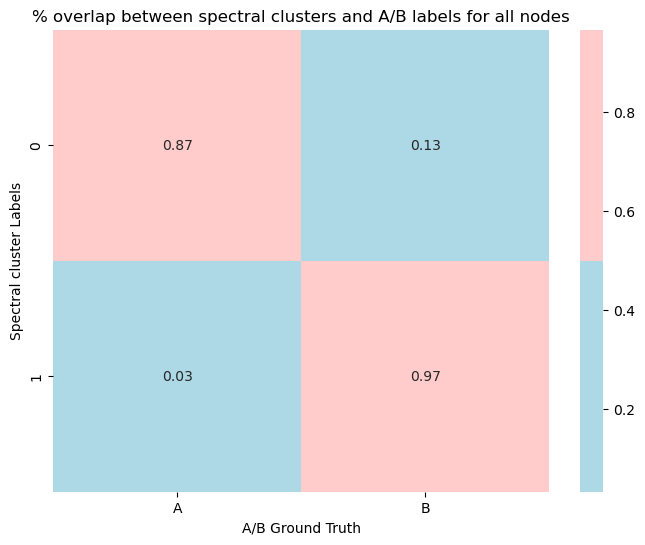

(0.9666666666666667, 0.8854961832061069, 0.9243027888446215)


In [3]:
## plot confusion matrix between cluster labels and ab scores ##
##### DEBUG : the conf matrix varies on each execution, need to fix this #####
from matplotlib.colors import ListedColormap

def plot_confusion_matrix_heatmap(confusion_matrix):
    """
    Plot the confusion matrix as a heatmap.

    Parameters:
    confusion_matrix (numpy.ndarray): A 2x2 confusion matrix.
    """
    cnf_mtx_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    gt_labels = ['A', 'B']
    cluster_labels = ['0', '1']
    colors = ['#add8e6', '#ffcccb']  # light red and blue
    cmap = ListedColormap(colors)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnf_mtx_norm, annot=True, fmt='.2f', cmap=cmap, xticklabels=gt_labels, yticklabels=cluster_labels)
    plt.xlabel('A/B Ground Truth')
    plt.ylabel('Spectral cluster Labels')
    plt.title('% overlap between spectral clusters and A/B labels for all nodes')
    plt.show()

config = Config()
nodeset_key = config.genomic_params.nodeset_key
conf_matx, accuracy_metrics = run_single_chrom_eval("chr1", config, 1000000, "1Mb", nodeset_key)
plot_confusion_matrix_heatmap(conf_matx)
print(accuracy_metrics) #precion, recall, f1 score
#F1 is better as not all chromosomes have equal number of A/B compartments

    chrom  precision    recall        f1
0    chr1   0.965812  0.862595  0.911290
1    chr2   0.186441  0.162963  0.173913
2    chr3   0.101124  0.079646  0.089109
3    chr4   0.657895  0.200000  0.306748
4    chr5   0.957447  0.420561  0.584416
5    chr6   0.978947  0.939394  0.958763
6    chr7   0.716418  0.905660  0.800000
7    chr8   1.000000  0.260000  0.412698
8    chr9   0.888889  0.096386  0.173913
9   chr10   0.355263  0.317647  0.335404
10  chr11   0.949367  0.842697  0.892857
11  chr12   0.941176  0.200000  0.329897
12  chr13   1.000000  0.030769  0.059701
13  chr14   0.967742  0.566038  0.714286
14  chr15   0.372881  0.458333  0.411215
15  chr16   1.000000  0.490566  0.658228
16  chr17   1.000000  0.418605  0.590164
17  chr18   1.000000  0.098039  0.178571
18  chr19   0.931034  0.931034  0.931034
19  chr20   1.000000  0.700000  0.823529
20  chr21   0.500000  0.068966  0.121212
21  chr22   0.482759  0.583333  0.528302
22   chrX   0.784314  0.434783  0.559441
23   chrY   1.00

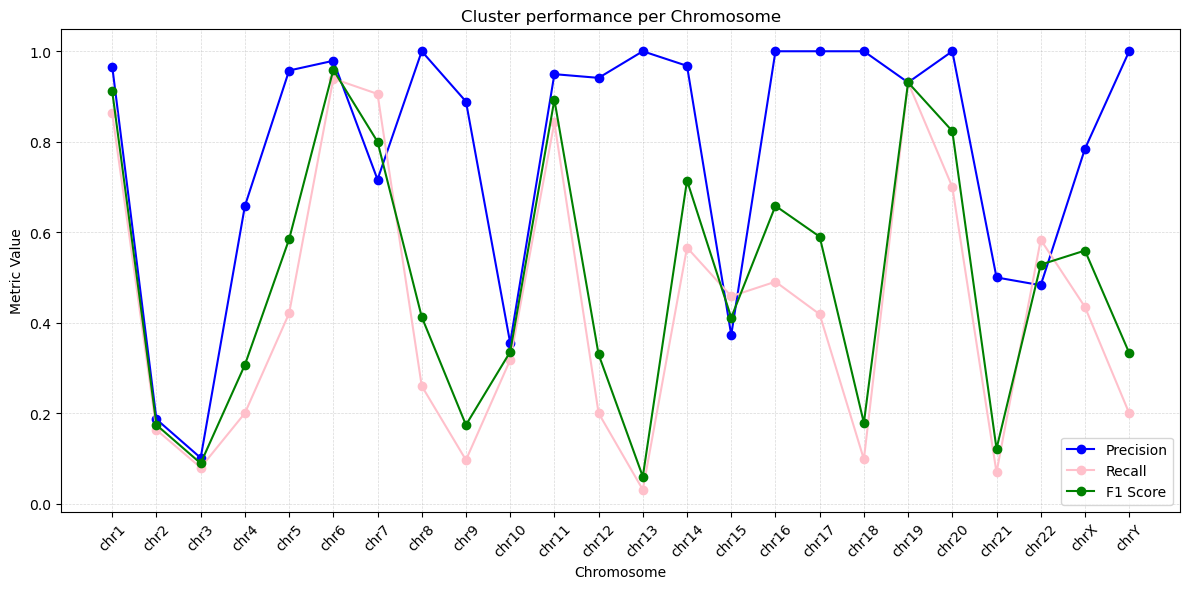

In [5]:
## whole genome accuracy metrics plot ##
metrics_file = os.path.join(config.paths.temp_dir, f"accuracy_metrics_{config.genomic_params.affinity_key}.csv")
metrics_df = pd.read_csv(metrics_file)
print(metrics_df)

# Plot the precision and recall per chromosome
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['chrom'], metrics_df['precision'], marker='o', label='Precision', color='blue')
plt.plot(metrics_df['chrom'], metrics_df['recall'], marker='o', label='Recall', color='pink')
plt.plot(metrics_df['chrom'], metrics_df['f1'], marker='o', label='F1 Score', color='green')
plt.xlabel('Chromosome')
plt.ylabel('Metric Value')
plt.title('Clustering performance per Chromosome')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cluster structural and physical properties evaluation

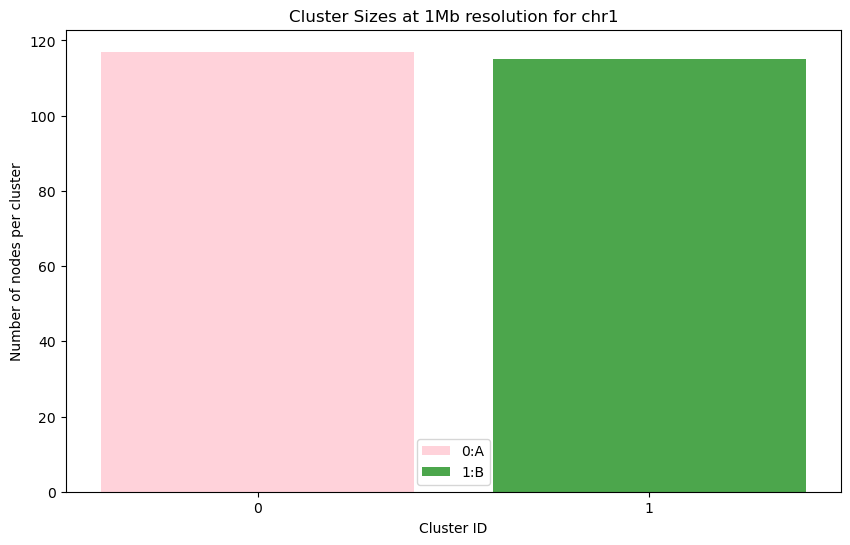

array([117, 115])

In [15]:
def cluster_size_distribution_single_chr(node_attrs_dict, chrom):
    """
    calculate cluster size distribution split between number of clusters; x = cluster_num, y = size
    input: nodeset dict {start: (set_idx, cluster_label)}
    """
    cluster_labels = [attr[1] for attr in node_attrs_dict.values()]
    # Count the number of nodes in each cluster
    cluster_sizes = np.bincount(cluster_labels)
    cluster_ids = np.arange(len(cluster_sizes))
    
    # Plot the cluster size distribution
    colors = ['pink', 'green']
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cluster_ids, cluster_sizes, color=colors, alpha=0.7)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of nodes per cluster')
    plt.title(f'Cluster Sizes at 1Mb resolution for {chrom}')
    plt.legend(bars, ['0:A', '1:B'])
    plt.xticks(ticks=[0, 1], labels=['0', '1'])
    plt.show()

    return cluster_sizes

#read nodeset_attrs from pkl file
chrom = "chr1"
node_attrs_dir = os.path.join(config.paths.temp_dir, f"affinity_matrices/{config.genomic_params.affinity_key}")
node_attrs_dict = pd.read_pickle(f"{node_attrs_dir}/{chrom}_nodeset_attrs.pkl") 
cluster_size_distribution_single_chr(node_attrs_dict, chrom)

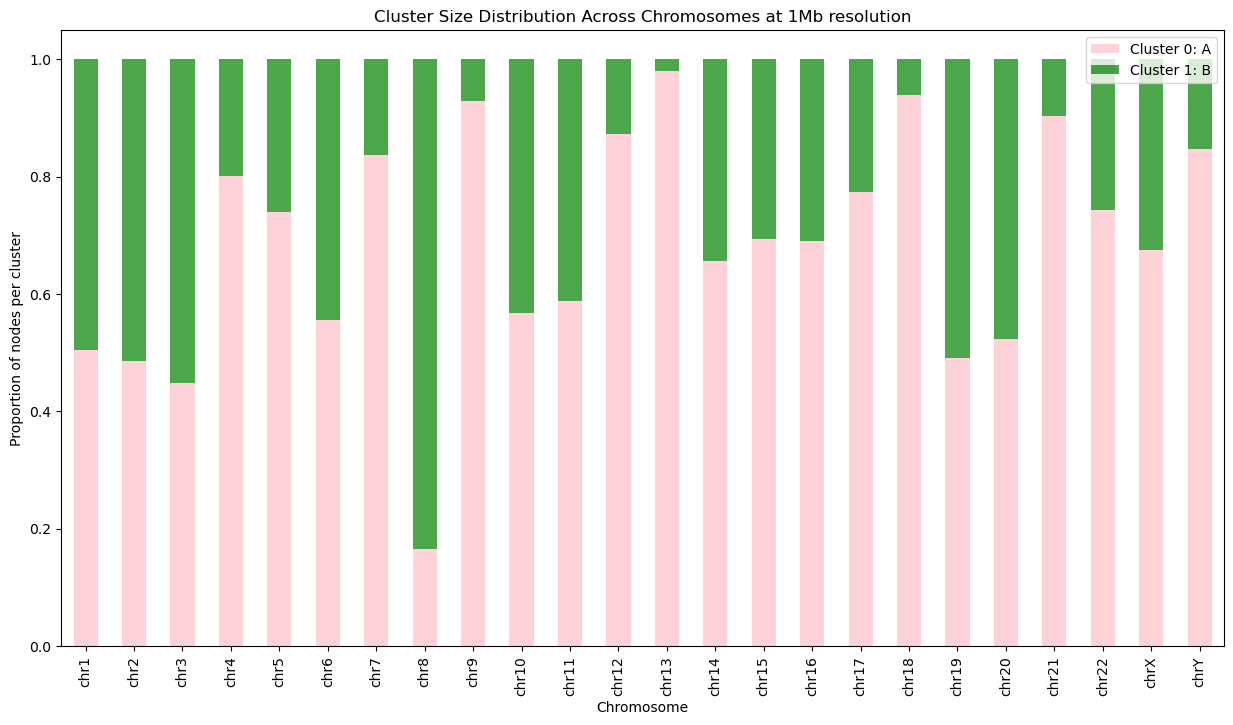

In [13]:
## whole genome cluster size plot ##
#get whole genome nodeset_attrs using for loop
##plot the cluster size distribution for whole genome

def cluster_size_distribution_whole_genome(chromosomes, node_attrs_dir):
    """
    Calculate cluster size distribution for the whole genome.
    Each bar represents a chromosome, split into proportions of clusters 0 and 1.
    Input: chrom_list (list of chromosome names), node_attrs_dir (directory containing nodeset_attrs.pkl files).
    """
    cluster_sizes = {}
    
    for chrom in chromosomes:
        # Load nodeset_attrs for the current chromosome
        nodeset_attrs_path = os.path.join(node_attrs_dir, f"{chrom}_nodeset_attrs.pkl")
        node_attrs_dict = pd.read_pickle(nodeset_attrs_path)
        
        # Extract cluster labels and count the number of nodes in each cluster
        cluster_labels = [attr[1] for attr in node_attrs_dict.values()]
        cluster_sizes[chrom] = np.bincount(cluster_labels)
    
    # Convert cluster sizes to a DataFrame for easier manipulation
    cluster_sizes_df = pd.DataFrame(cluster_sizes).T.fillna(0)
    cluster_sizes_df.columns = ['Cluster 0', 'Cluster 1']
    
    # Calculate proportions
    total_sizes = cluster_sizes_df.sum(axis=1)
    cluster_proportions = cluster_sizes_df.divide(total_sizes, axis=0)
    
    # Plot the stacked bar plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Define colors for each cluster
    colors = ['pink', 'green']
    
    # Create stacked bar plot
    cluster_proportions.plot(kind='bar', stacked=True, color=colors, alpha=0.7, ax=ax)
    
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Proportion of nodes per cluster')
    ax.set_title('Cluster Size Distribution Across Chromosomes at 1Mb resolution')
    ax.legend(['Cluster 0: A', 'Cluster 1: B'])
    
    plt.show()

#read nodeset_attrs from pkl file
node_attrs_dir = os.path.join(config.paths.temp_dir, f"affinity_matrices/{config.genomic_params.affinity_key}")
chromosomes = config.genomic_params.chromosomes
cluster_size_distribution_whole_genome(chromosomes, node_attrs_dir)